# Data preparation

In [163]:
def split_features_by_type(_df):
    def array_diff(a, b):
        b = set(b)
        return [aa for aa in a if aa not in b]
    
    all_features = [c for c in _df.columns if c!='Vote']
    discrete_features = [c for c in _df.columns if len(_df[c].unique())<=20 and c!='Vote']
    continuous_features = array_diff(all_features, discrete_features)
    return [all_features, discrete_features, continuous_features]

In [164]:
def mark_negative_values_as_nan(_df):
    print 'mark_negative_values_as_nan'
    positive_features = ['Avg_monthly_expense_when_under_age_21', 'AVG_lottary_expanses', 'Avg_Residancy_Altitude']
    print 'Before:'
    print _df[positive_features].min()

    for f in positive_features:
        _df[f] = _df[f].map(lambda x: x if x >= 0 else np.nan)

    print '\nAfter:'
    print _df[positive_features].min()

In [165]:
def outlier_detection(_df):
    """
    for all continuous features: keep only values that are within +3 to -3 standard deviations, otherwise set nan
    """
    
    for f in CONTINUOUS_FEATURES:
        std = _df[f].std()
        mean = _df[f].mean()
        _df[f] = _df[f].map(lambda x: x if np.abs(x-mean)<=(3*std) else np.nan)

In [166]:
def fill_missing_values_in_linear_depended_features(_df):
    """
    Avg_Residancy_Altitude and Avg_monthly_expense_when_under_age_21 are linear depended in each other.
    We can use that in order to filling the missing values in each other
    """
    
    _df.plot(x='Avg_Residancy_Altitude', y='Avg_monthly_expense_when_under_age_21')

    xValues = _df['Avg_Residancy_Altitude'].values
    yValues = _df['Avg_monthly_expense_when_under_age_21'].values
    m = (yValues[0] - yValues[1]) / (xValues[0] - xValues[1])
    const = yValues[0] - (m * xValues[0])

    def get_avg_monthly_expense_when_under_age_21(avg_Residancy_Altitude_value):
        return const + (m * avg_Residancy_Altitude_value)

    def fill_avg_monthly_expense_when_under_age_21(row):
        if row['Avg_Residancy_Altitude'] >=0:
            row['Avg_monthly_expense_when_under_age_21'] = get_avg_monthly_expense_when_under_age_21(row['Avg_Residancy_Altitude'])
        return row

    _df = _df.apply(fill_avg_monthly_expense_when_under_age_21, axis=1)

    # TODO: fill Avg_Residancy_Altitude by Avg_monthly_expense_when_under_age_21

In [167]:
import numpy as np

def categorical_features_tranformation(_df):

    # Identify which of the orginal features are objects
    ObjFeat=_df.keys()[_df.dtypes.map(lambda x: x=='object')]

    # Transform the original features to categorical
    for f in ObjFeat:
        _df[f] = _df[f].astype("category")
        _df[f+"Int"] = _df[f].cat.rename_categories(range(_df[f].nunique())).astype(int)
        _df.loc[_df[f].isnull(), f+"Int"] = np.nan #fix NaN conversion
        _df[f]=_df[f+"Int"]
        del _df[f+"Int"]

In [168]:
import numpy as np
from sklearn.preprocessing import Imputer

def fill_missing_values_with_em(_df=np.nan):
    """
    We assume that the data are missing completely at random
    """
    return

def fill_missing_values_with_naive_imputer(_df):
    # for discrete features we will use 'most_frequent' strategy
    imp_discrete = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    _df[DISCRETE_FEATURES] = imp_discrete.fit_transform(_df[DISCRETE_FEATURES].values)
    
    # for continuous features we will use 'mean' strategy
    imp_continuous = Imputer(missing_values='NaN', strategy='mean', axis=0)
    _df[CONTINUOUS_FEATURES] = imp_continuous.fit_transform(_df[CONTINUOUS_FEATURES].values)
    
def drop_missing_values(_df):
    _df.dropna(inplace=True)

In [169]:
from sklearn import preprocessing

def z_score_scaling(_df):
    scaler = preprocessing.StandardScaler().fit(_df[CONTINUOUS_FEATURES])
    _df[CONTINUOUS_FEATURES] = scaler.transform(_df[CONTINUOUS_FEATURES])

In [170]:
def reduce_last_school_grades(_df):
    _df['Last_school_grades'] = _df['Last_school_grades'].map(lambda x: 60 if x >= 60 else x)

In [171]:
def print_missing_values(df):
    print '\n\nMissing values:'
    for col in df.columns.values:
        misCount = df[col].isnull().sum()
        if misCount > 0:
            print '%s: %s missing values' % (col, misCount)

def plot_log_density_function(df, column):
    plot_density_function(df, column, lambda x: math.log(x))


def plot_density_function(df, column, trans=lambda x: x):
    df[column].plot(kind='kde')    
    # p.savefig('foo.png')
    # p.clf()
    p.show()

# Filters

In [172]:
from sklearn.feature_selection import chi2

def chi2_filter(_df):
    print 'chi2:'
    alpha = 0.05
    X = _df.drop(['Vote'], axis=1).values
    Y = _df.Vote.values
    v=chi2(X, Y)[1]
    i=0
    for c in ALL_FEATURES:
        if c in DISCRETE_FEATURES:
            print  str(v[i]) +": " + c
            if v[i]<alpha:
                FEATURES_TO_KEEP.append(c)            
        i+=1

In [173]:
import sklearn

def anova_filter(_df):
    print 'anova:'
    alpha = 0.05
    X = _df.drop(['Vote'], axis=1).values
    Y = _df.Vote.values
    v=sklearn.feature_selection.f_classif(X, Y)[1]
    i=0
    for c in _df.drop(['Vote'], axis=1).columns:
        if c not in DISCRETE_FEATURES:        
            print  str(v[i]) + ": " + c
            if v[i]<alpha:
                FEATURES_TO_KEEP.append(c)            
        i+=1

# Wrappers

In [174]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold

def wrappersTest(X, Y, kf): 
    classifiers = {
        "Nearest Neighbors": KNeighborsClassifier(15),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(max_depth=5),
        "Perceptron": Perceptron(n_iter=50),
    #     "Linear SVM OVO": SVC(kernel="linear", C=1),
        "Linear SVM OVR": LinearSVC(C=1),
        "Random Forest": RandomForestClassifier(n_estimators = 3)
    }
    res = {}
    for name, clf in classifiers.iteritems():
        score_sum=0 
        print 'start ' + str(name) + ' test..'
        for k, (train_index, test_index) in enumerate(kf):            
            clf.fit(X[train_index], Y[train_index])            
            acc = clf.score(X[test_index],Y[test_index])
            score_sum += acc                 
#             print("[fold {0}] {1} score: {2:.5}".format(k, name, acc))
        print("{0} average score: {1:.5}".format(name, score_sum/kf.n_folds))
        res[name] = score_sum/kf.n_folds
    return res

def evaulate_features(_df, similar_features):    
    n_folds=5
    kf = KFold(n=len(_df), n_folds=n_folds)
    Y = _df.Vote.values
    
    res = {}
    print 'Wrappers score with all selected features:'
    res['all'] = wrappersTest(_df[FEATURES_TO_KEEP].values, Y, kf)
    
    print 'Wrappers score without similar_features:'
    res['withou similar_features'] = wrappersTest(_df[FEATURES_TO_KEEP].drop(similar_features, axis=1).values, Y, kf)

    for s in similar_features:   
        print 'Wrappers score without ' + str(s) + ':'
        res[s] = wrappersTest(_df[FEATURES_TO_KEEP].drop(s, axis=1).values, Y, kf)
        
    print pd.DataFrame.from_dict(res)    
    return res

In [175]:
def SFS(df, label, classifier, max_out_size, n_folds=5):
    kf = KFold(n=len(df), n_folds=n_folds)
    labels = df[label].values
    selected_features = []
    not_selected_features = list(df.columns)
    not_selected_features.remove(label)
    last_score = 0
    while len(selected_features) < max_out_size and len(not_selected_features)>0:
        max = 0
        for feature in not_selected_features:
            score = get_score(df[selected_features+[feature]].values, labels, classifier, kf)
            if score > max:
                max=score
                best_feature=feature
        if max<last_score:
            print 'no improvemant by adding any feature'
            break
        selected_features.append(best_feature)
        not_selected_features.remove(best_feature)
        last_score=max
        print 'selected feature: ' + best_feature + ' with score ' + str(max)
    return selected_features
        
def get_score(X, Y, clf, kf):
    score_sum=0
    for k, (train_index, test_index) in enumerate(kf):
        clf.fit(X[train_index], Y[train_index])
        acc = clf.score(X[test_index],Y[test_index])
        score_sum += acc
    return score_sum/kf.n_folds

# Looking at the data

mark_negative_values_as_nan
Before:
Avg_monthly_expense_when_under_age_21     -394.030092
AVG_lottary_expanses                    -81744.489527
Avg_Residancy_Altitude                    -131.343364
dtype: float64

After:
Avg_monthly_expense_when_under_age_21     3.988911
AVG_lottary_expanses                     44.957092
Avg_Residancy_Altitude                    1.329637
dtype: float64
chi2:
0.00939338014421: Occupation_Satisfaction
0.0: Most_Important_Issue
0.0: Looking_at_poles_results
2.11157371268e-116: Married
0.979486951977: Gender
0.543189363847: Voting_Time
2.5239068613e-76: Will_vote_only_large_party
0.0: Last_school_grades
0.628214501735: Age_group
0.998027503891: Number_of_differnt_parties_voted_for
0.25193533582: Main_transportation
0.0657004618364: Occupation
0.0908765513724: Num_of_kids_born_last_10_years
0.0: Financial_agenda_matters


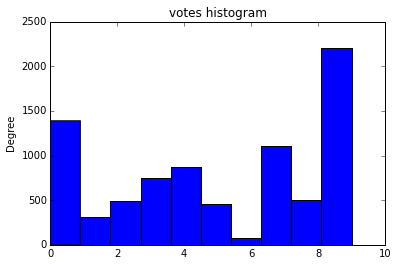

In [176]:
%matplotlib inline
import math
import pandas as pd
import pylab as p

df = pd.read_csv('./dataset/ElectionsData.csv')
ALL_FEATURES, DISCRETE_FEATURES, CONTINUOUS_FEATURES = split_features_by_type(df)
FEATURES_TO_KEEP=[]
mark_negative_values_as_nan(df)
categorical_features_tranformation(df)
drop_missing_values(df)
df.Vote.plot(kind='hist',title='votes histogram')
chi2_filter(df)

Some of the continous features are uniformly distributed, we can see that from their KDEs:

0.0: Avg_monthly_expense_when_under_age_21


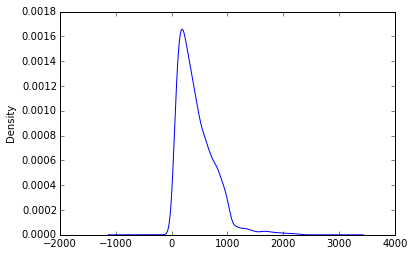

0.0: AVG_lottary_expanses


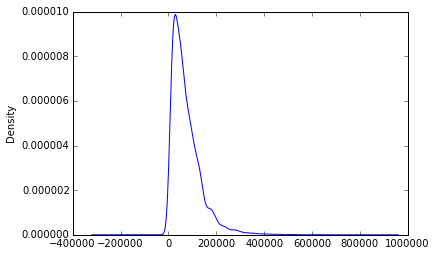

0.0: Avg_Residancy_Altitude


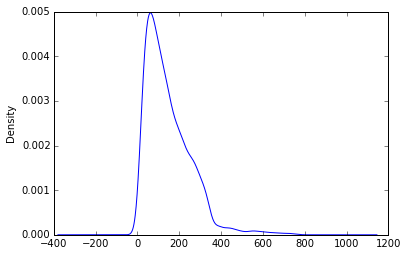

0.0: Yearly_ExpensesK


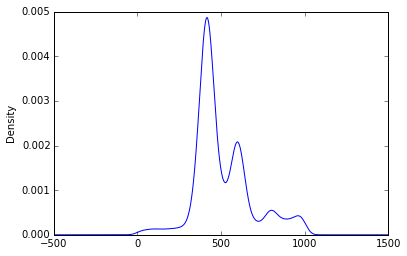

2.10194769649e-44: Financial_balance_score_(0-1)


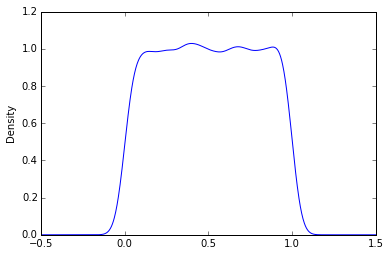

1.07899981753e-43: %Of_Household_Income


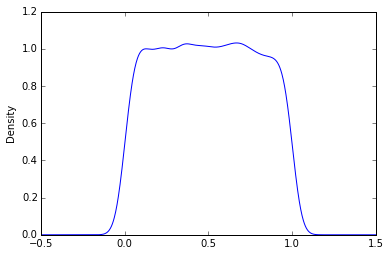

1.12103877146e-44: Avg_government_satisfaction


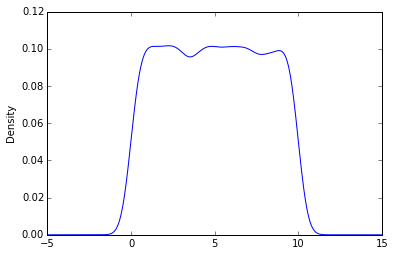

5.6051938573e-45: Avg_education_importance


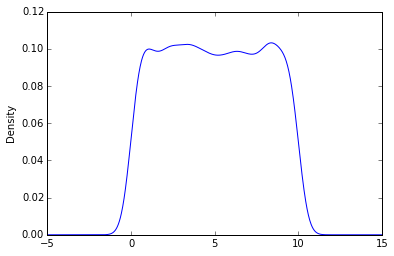

2.80259692865e-44: Avg_environmental_importance


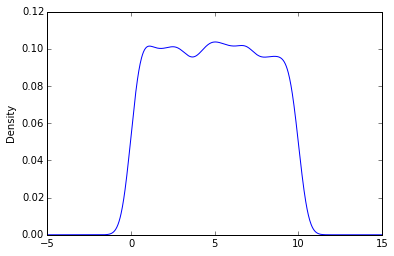

6.86636247519e-44: Avg_Satisfaction_with_previous_vote


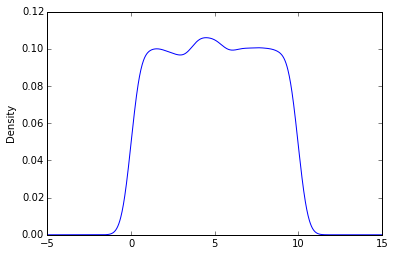

3.78350585368e-44: Avg_monthly_income_all_years


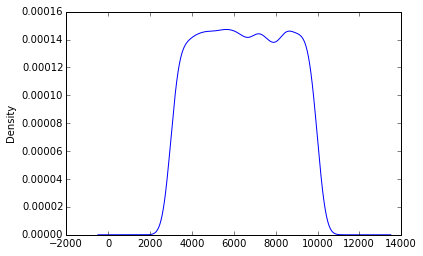

2.38220738935e-44: %Time_invested_in_work


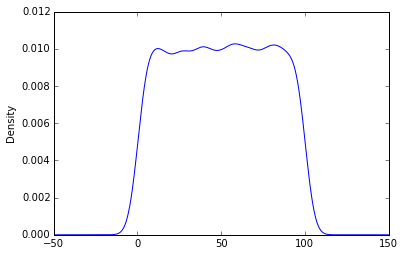

0.0: Yearly_IncomeK


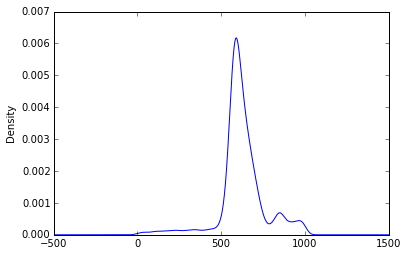

0.0: Avg_monthly_expense_on_pets_or_plants


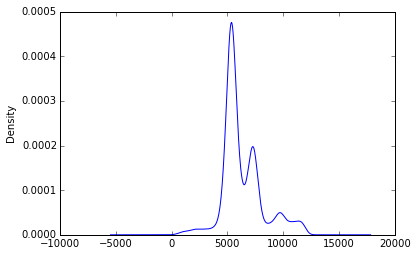

0.0: Avg_monthly_household_cost


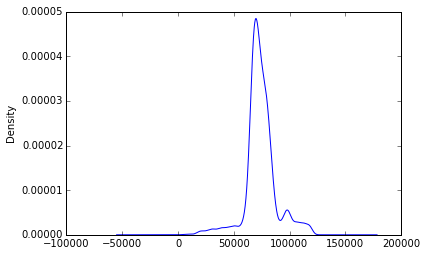

0.0: Phone_minutes_10_years


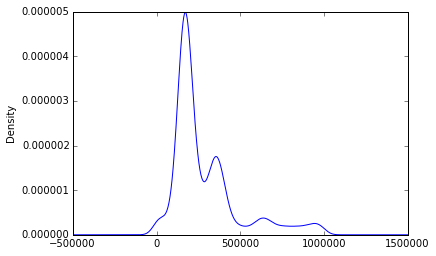

0.0: Avg_size_per_room


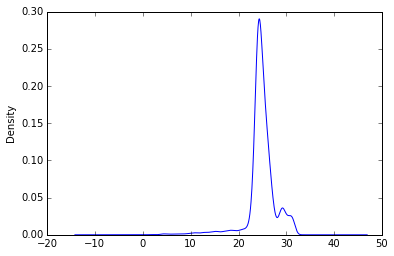

0.0: Weighted_education_rank


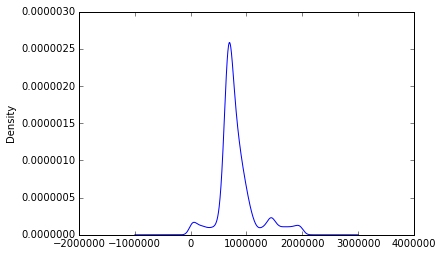

1.26116861789e-44: %_satisfaction_financial_policy


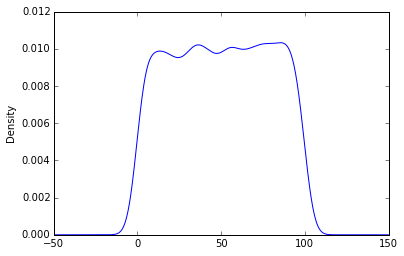

0.0: Garden_sqr_meter_per_person_in_residancy_area


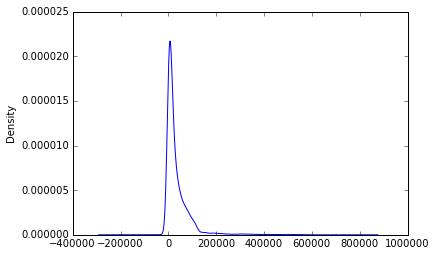

0.0: Political_interest_Total_Score


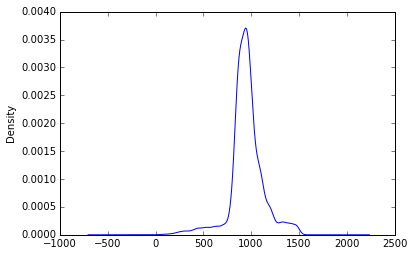

0.0: Overall_happiness_score


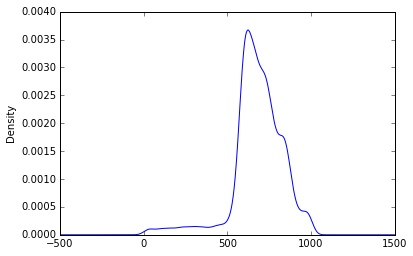

In [177]:
from scipy.stats import shapiro
# print('scipy:', scipy.__version__)
i=0
uniform =[]
for c in all_features:
    if c not in discrete_features:
        #test for normal distribution
        v=shapiro(df[c])[1]
        print str(v) + ": " + c
        if v>0:
            uniform.append(c)            
        plot_density_function(df,c)
    i+=1

We would like to convert them to normal:

In [178]:
from scipy.stats import norm 
def uniform_to_normal(df):    
    zero_to_one = [f for f in uniform if df[f].min()>0 and df[f].min()<0.001 and df[f].max()<1 and df[f].max()>0.999]
    zero_to_ten = [f for f in uniform if df[f].min()>0 and df[f].min()<0.01 and df[f].max()<10 and df[f].max()>9.99]
    zero_to_hundred = [f for f in uniform if df[f].min()>0 and df[f].min()<0.1 and df[f].max()<100 and dfNormal[f].max()>99.9]
    for f in uniform:    
        min= 0 if f in zero_to_one or f in zero_to_ten or f in zero_to_hundred else df[f].min()
        max= 1 if f in zero_to_one else (10 if f in zero_to_ten else 100 if f in zero_to_hundred else df[f].max())
        df[f] = df[f].map(lambda x: norm.ppf((x-min)/(max-min))) 
        
uniform_to_normal(df)

In [179]:
z_score_scaling(df)
anova_filter(df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#All the features that were uniformly distributed seem insignificant by Anova test, did we do anything wrong? 
#Lets print their mean by vote:

votes=df.Vote.unique()
votes.sort()

for c in df.columns:
    if c in uniform:
        print c
        for vote in votes:                                
            print str(vote) + ": "  + str(df[df.Vote==vote][c].mean())

None of them seem meaningful

#### Comparing KDE's between classes:

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

votes=df.Vote.unique()
votes.sort()

for c in ALL_FEATURES:
    if c not in FEATURES_TO_KEEP: #only look at features we still have'nt found any reason to keep    
        if c not in DISCRETE_FEATURES: # this is only relevant for non-discrete features
            print c + ": " +  str(c in FEATURES_TO_KEEP)
            for vote in votes:                                
                df[df.Vote==vote][c].plot(kind='kde')            
            plt.show()

Conclusion: no new evidence to keep any of those features

#### Let's look at the features we did decide to keep

In [ ]:
for c in df.columns:
    if c in FEATURES_TO_KEEP: # lets see if there are redundant features we decided to keep
        if c not in DISCRETE_FEATURES: # this is only relevant for non-discrete features
            print c + ": " +  str(c in FEATURES_TO_KEEP)
            for vote in votes:                                
                df[df.Vote==vote][c].plot(kind='kde')            
            plt.show()

In [ ]:
# these 2 look the same
df.plot(x='Avg_monthly_expense_when_under_age_21', y='Avg_Residancy_Altitude')

Yes, they are linearly dependent, so we can drop one of them, and even use it to fill the other one's missing data

In [ ]:
#these two look pretty similar too
df.plot(x='Yearly_ExpensesK', y='Avg_monthly_expense_on_pets_or_plants')

Not sure if thats close enough to drop one of them, let's keep them for now

#### for discrete features, lets compare histograms of votes between different values

In [ ]:
for c in DISCRETE_FEATURES:
    print c + ": " +  ('' if(c in FEATURES_TO_KEEP) else 'not ') + 'selected'
    ct = pd.crosstab(df[c], df.Vote)
    ctn=ct.div(ct.sum(axis=1), axis=0).div(ct.sum(axis=0), axis=1) #normalize
    ctn.plot(kind='bar', figsize = (15,5)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()    
    #lets also print the KDEs, maybe it will help    
    if len(df[c].unique())>2:
        for vote in votes:                                        
            df[df.Vote==vote][c].plot(kind='kde')            
    plt.show()

Occupation_Satisfaction- looks different for party 6 when value is 4 and 10, BUT 6 is a very small party, so using this is probably overfitting

Number_of_differnt_parties_voted_for - looks like it does matter, at least for values greater than 4. The qeustion is, do people who voted for a large number of parties tend to vote more for a certain party (party 1 got a very high value with people who voted for 7 different parties) or maybe the histogram looks like this simply because less people have higher values (let's print the histogram), but it doesn't help us predict who will they vote to.
Since the outstanding numbers in the histograms (when exist) are for small parties, and the histograms are very different between the high numbers (the parties with more votes are not consistent) we believe it's just noise.

Num_of_kids_born_last_10_years - same

Last_school_grades - looks like it doesn't matter when 60 or above, we should probably reduce all these values to one. 

In [ ]:
print 'Number_of_differnt_parties_voted_for'
df.Number_of_differnt_parties_voted_for.plot(kind='hist')
plt.show()

print 'Num_of_kids_born_last_10_years'
df.Num_of_kids_born_last_10_years.plot(kind='hist')
plt.show()

So it looks like we were right, and those features are not important, they weren't included anyway.

Looking at the KDE's we see two groups of features that look similar: ['Avg_monthly_expense_when_under_age_21', 'AVG_lottary_expanses', 'Garden_sqr_meter_per_person_in_residancy_area']
and :[todo]

In [ ]:
evaulate_features(df, 
                  ['Avg_monthly_expense_when_under_age_21', 'AVG_lottary_expanses', 'Garden_sqr_meter_per_person_in_residancy_area'])

# Feature selection - with data preparation

mark_negative_values_as_nan
Before:
Avg_monthly_expense_when_under_age_21     -394.030092
AVG_lottary_expanses                    -81744.489527
Avg_Residancy_Altitude                    -131.343364
dtype: float64

After:
Avg_monthly_expense_when_under_age_21     3.988911
AVG_lottary_expanses                     44.957092
Avg_Residancy_Altitude                    1.329637
dtype: float64
chi2:
0.00365911880202: Occupation_Satisfaction
0.0: Most_Important_Issue
0.0: Looking_at_poles_results
6.2254237442e-147: Married
0.994843871005: Gender
0.509510829892: Voting_Time
1.11145126531e-94: Will_vote_only_large_party
0.0: Last_school_grades
0.697201100906: Age_group
0.998062432461: Number_of_differnt_parties_voted_for
0.623318625509: Main_transportation
0.140801629388: Occupation
0.0909226329392: Num_of_kids_born_last_10_years
0.0: Financial_agenda_matters
anova:
1.50355485475e-228: Avg_monthly_expense_when_under_age_21
4.70838625817e-153: AVG_lottary_expanses
1.5483098529e-232: Avg_Residancy_

KeyboardInterrupt: 

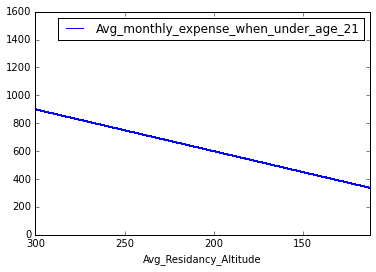

In [87]:
import pandas as pd
df = pd.read_csv('./dataset/ElectionsData.csv')

ALL_FEATURES, DISCRETE_FEATURES, CONTINUOUS_FEATURES = split_features_by_type(df)
FEATURES_TO_KEEP=[]

mark_negative_values_as_nan(df)
outlier_detection(df)
fill_missing_values_in_linear_depended_features(df)
categorical_features_tranformation(df)
fill_missing_values_with_naive_imputer(df)
reduce_last_school_grades(df)
chi2_filter(df)
z_score_scaling(df)
anova_filter(df)
evaulate_features(df)

sfs=SFS(df, 'Vote', RandomForestClassifier(n_estimators = 3), 18)
print "features in sfs we didn't select:"
for f in sfs:
    if f not in FEATURES_TO_KEEP:
        print f
print ''
print "features we selected and sfs didn't:"
for f in FEATURES_TO_KEEP:
    if f not in sfs:
        print f

# as we saw - Avg_Residancy_Altitude and Avg_monthly_expense_when_under_age_21 are linearly dependant
FEATURES_TO_KEEP.remove('Avg_Residancy_Altitude')

# if we run out test on df_ we will get that 'Occupation_Satisfaction' is part of the selected features
print FEATURES_TO_KEEP

# Feature selection - with naive data preparation (drop na)

In [ ]:
import pandas as pd
df = pd.read_csv('./dataset/ElectionsData.csv')

ALL_FEATURES, DISCRETE_FEATURES, CONTINUOUS_FEATURES = split_features_by_type(df)
FEATURES_TO_KEEP=[]

mark_negative_values_as_nan(df)
# outlier_detection(df)
# fill_missing_values_in_linear_depended_features(df)
categorical_features_tranformation(df)
# fill_missing_values_with_naive_imputer(df)
drop_missing_values(df)
# reduce_last_school_grades(df)
chi2_filter(df)
z_score_scaling(df)
anova_filter(df)
evaulate_features(df)

sfs=SFS(df, 'Vote', RandomForestClassifier(n_estimators = 3), 18)
print "features in sfs we didn't select:"
for f in sfs:
    if f not in FEATURES_TO_KEEP:
        print f
print ''
print "features we selected and sfs didn't:"
for f in FEATURES_TO_KEEP:
    if f not in sfs:
        print f

# as we saw - Avg_Residancy_Altitude and Avg_monthly_expense_when_under_age_21 are linearly dependant
FEATURES_TO_KEEP.remove('Avg_Residancy_Altitude')

# if we run out test on df_ we will get that 'Occupation_Satisfaction' is part of the selected features
print FEATURES_TO_KEEP